<a href="https://colab.research.google.com/github/harim061/FakeNewsDetection/blob/main/fakeNews_3%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 메소드

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
!pip install contractions
import contractions
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, precision_score, \
                             recall_score, f1_score, roc_curve, \
                             accuracy_score, roc_auc_score
from sklearn.model_selection import ParameterGrid, GridSearchCV


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras.layers import  Embedding
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, GRU, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.callbacks import EarlyStopping

from __future__ import absolute_import, division, print_function, unicode_literals

VOCAB_SIZE = 5000

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 6.4 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
path = '/content/drive/MyDrive/kaggle_data/'
test= pd.read_csv(path + 'test.csv'  )
train= pd.read_csv(path + 'train.csv' )
submit= pd.read_csv(path + 'submit.csv')

# 데이터 전처리

In [3]:
def data_clean(dt):
  dt = dt.fillna('')
  dt["total"] = dt['title'] + " " + dt["author"]
  return dt

In [4]:

def text_cleaning(df):
    ps = PorterStemmer()
    corpus = []
    for i in range(len(df)):
        m = re.sub("[^a-zA-Z]", " ", df["total"][i])
        m = m.lower()
        m = m.split()
        m = [ps.stem(word) for word in m if not word in stopwords.words('english')]
        clean_text = " ".join(m)
        corpus.append(clean_text)
    return corpus


In [5]:
def onehot(corpus, VOCAB_SIZE = 5000):
  return [one_hot(words, VOCAB_SIZE) for words in corpus]

In [6]:
def padding(onehot_text) :
  return np.array(pad_sequences(onehot_text, padding="pre", maxlen = 25))

In [7]:
def get_label(df):
  return np.array(df["label"])

In [8]:
def make_clean(df) :
  corpus = data_clean(df)
  corpus = text_cleaning(corpus)
  corpus = onehot(corpus)
  corpus = padding(corpus)
  return   corpus

In [9]:
def get_data() :
  path = '/content/drive/MyDrive/kaggle_data/'
  test   = pd.read_csv(path + 'test.csv'  )
  train  = pd.read_csv(path + 'train.csv' )
  submit = pd.read_csv(path + 'submit.csv')

  x = np.array(list(make_clean(train)) + list(make_clean(test )))
  y = np.array(list(get_label(train )) + list(get_label(submit)))
  return train_test_split(x, y, test_size = 0.1, random_state = 1234)

In [10]:

def save_data(path, train_x, test_x, train_y, test_y) :
  np.save(path + 'train_x', train_x)
  np.save(path + 'test_x' , test_x )
  np.save(path + 'train_y', train_x)
  np.save(path + 'test_y' , test_x )

In [11]:

train_x, test_x, train_y, test_y = get_data()

save_data(path, train_x, test_x, train_y, test_y)

In [12]:
train_x,val_x,train_y,val_y = train_test_split(train_x,train_y,test_size = 0.1,random_state = 1234)

In [13]:
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)
print(test_x.shape)
print(test_y.shape)

(21060, 25)
(21060,)
(2340, 25)
(2340,)
(2600, 25)
(2600,)


# 모델링 - CNN-LSTM

In [14]:
train_x.shape

(21060, 25)

In [15]:
model_CNN_LSTM = Sequential()
model_CNN_LSTM.add(keras.layers.Embedding(30000, 30))
model_CNN_LSTM.add(keras.layers.Dropout(0.3))
model_CNN_LSTM.add(keras.layers.Conv1D(32, 3, padding='same', strides=1,activation='relu'))
model_CNN_LSTM.add(keras.layers.MaxPooling1D(2))
model_CNN_LSTM.add(LSTM(100))
model_CNN_LSTM.add(keras.layers.Dropout(0.3))
model_CNN_LSTM.add(Dense(1, activation='sigmoid'))
model_CNN_LSTM.compile(optimizer = 'Adam', loss='binary_crossentropy', metrics=['acc'])
history_CNN_LSTM = model_CNN_LSTM.fit(train_x, train_y, epochs=10,
                    validation_data=(val_x, val_y))
model_CNN_LSTM.summary()



Epoch 1/10
659/659 [==============================] - 21s 26ms/step - loss: 0.3327 - acc: 0.8763 - val_loss: 0.2573 - val_acc: 0.9175
Epoch 2/10
659/659 [==============================] - 17s 25ms/step - loss: 0.2463 - acc: 0.9211 - val_loss: 0.2545 - val_acc: 0.9205
Epoch 3/10
659/659 [==============================] - 17s 25ms/step - loss: 0.2217 - acc: 0.9264 - val_loss: 0.2578 - val_acc: 0.9150
Epoch 4/10
659/659 [==============================] - 21s 31ms/step - loss: 0.2002 - acc: 0.9316 - val_loss: 0.2744 - val_acc: 0.9120
Epoch 5/10
659/659 [==============================] - 17s 25ms/step - loss: 0.1755 - acc: 0.9380 - val_loss: 0.3090 - val_acc: 0.9017
Epoch 6/10
659/659 [==============================] - 17s 26ms/step - loss: 0.1514 - acc: 0.9472 - val_loss: 0.3166 - val_acc: 0.9034
Epoch 7/10
659/659 [==============================] - 17s 25ms/step - loss: 0.1284 - acc: 0.9538 - val_loss: 0.3699 - val_acc: 0.8962
Epoch 8/10
659/659 [==============================] - 17s 25ms

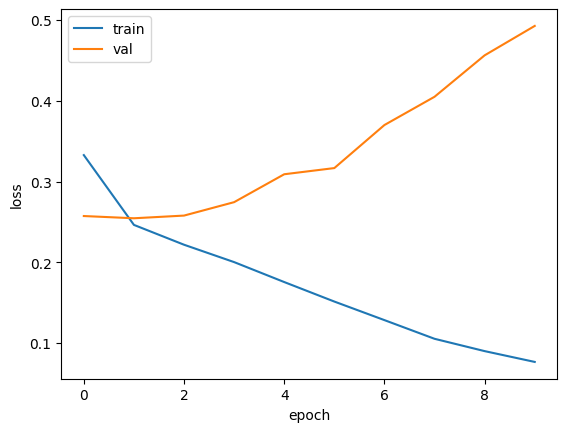

In [16]:
plt.plot(history_CNN_LSTM.history['loss'])
plt.plot(history_CNN_LSTM.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [17]:
model_CNN_LSTM.evaluate(val_x, val_y)

74/74 [==============================] - 0s 4ms/step - loss: 0.4926 - acc: 0.8795


[0.4926426112651825, 0.879487156867981]

# test set 예측

In [18]:
def show_metrics(y_pred, y_actual) :
  print('Accuracy  :',  accuracy_score(y_pred, y_actual))
  print('Precision :', precision_score(y_pred, y_actual))
  print('Recall    :',    recall_score(y_pred, y_actual))
  print('F1-score  :',        f1_score(y_pred, y_actual))
  print('Auc       :',   roc_auc_score(y_pred, y_actual))


In [19]:
def show_confusion_matrix(y_pred, y_actual, path, model_name) :
  fig = plt.figure(figsize = (10, 8))
  plt.title(model_name + ' Confusion Matrix')
  sns.heatmap(confusion_matrix(y_pred, y_actual), annot = True, fmt = 'd',
              cbar = False, cmap = sns.color_palette("Purples",2),
              xticklabels = ['Positive', 'Negative'],
              yticklabels = ['Positive', 'Negative'])
  plt.xlabel('Actuals')
  plt.ylabel('Predicted')
  plt.savefig(path + model_name +'_confusion_matrix.png', dpi = 300)
  plt.show()

In [20]:
model_CNN_LSTM.evaluate(test_x,test_y)

82/82 [==============================] - 0s 4ms/step - loss: 0.5715 - acc: 0.8608


[0.5715237259864807, 0.8607692122459412]

In [21]:
y_pred = (model_CNN_LSTM.predict(test_x) > 0.5).astype("int32")
path2 = '/content/drive/MyDrive/ML2/'
model_CNN_LSTM.save(path2 + 'CNN_LSTM.h5')

82/82 [==============================] - 1s 4ms/step


Accuracy  : 0.8607692307692307
Precision : 0.8615733736762481
Recall    : 0.8641881638846738
F1-score  : 0.8628787878787878
Auc       : 0.8607212270281404


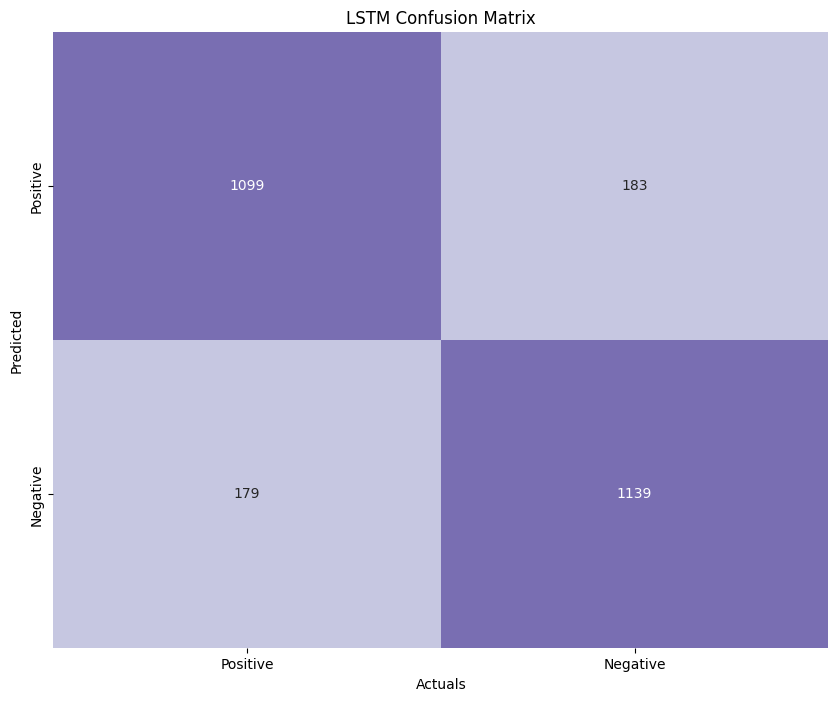

In [22]:
show_metrics(y_pred, test_y)
show_confusion_matrix(y_pred, test_y, path2, 'LSTM')

# 새로운 문장 예측

In [26]:
!pip install translate

In [29]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=1621598b01929648e4b26703fadff5f4ec0769bc0f7ece47a84843c958c9f6aa
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [30]:
from translate import Translator
from langdetect import detect

def get_prediction_from_user():
    translator = Translator(from_lang="ko", to_lang="en") # 번역 객체를 생성합니다.

    while True:
        # 사용자에게 뉴스 제목을 입력받습니다.
        title = input("뉴스 제목을 입력하세요 (0을 입력하면 종료됩니다.): ")

        # 입력받은 제목이 '0'이라면 함수를 종료합니다.
        if title == '0':
            print("Program terminated.")
            break

        # 사용자에게 뉴스 내용을 입력받습니다.
        content = input("뉴스 내용을 입력하세요: ")

        # 입력받은 제목과 내용이 한국어라면 영어로 번역합니다.
        if detect(title) != 'en':
            title = translator.translate(title)
        if detect(content) != 'en':
            content = translator.translate(content)

        # 번역된 제목과 내용을 데이터프레임으로 만듭니다.
        user_df = pd.DataFrame([[title, content]], columns=["title", "author"])

        # 데이터를 전처리합니다.
        user_data_clean = data_clean(user_df)
        user_corpus = text_cleaning(user_data_clean)
        user_onehot_text = onehot(user_corpus)
        user_tokens_pad = padding(user_onehot_text)

        # 예측을 수행합니다.
        prediction = model_CNN_LSTM.predict(user_tokens_pad)

        # 예측 결과를 출력합니다.
        if prediction > 0.5:
            print("This news is likely to be fake.")
        else:
            print("This news is likely to be real.")
        print(prediction)

# 함수를 실행합니다.
get_prediction_from_user()


뉴스 제목을 입력하세요 (0을 입력하면 종료됩니다.): U.S. Supreme Court Legalizes Same-Sex Marriage Nationwide
뉴스 내용을 입력하세요: In a historic 5-4 ruling, the Supreme Court of the United States ruled in favor of same-sex marriage on June 26, 2015. The decision grants same-sex couples the same legal rights and benefits as those afforded to heterosexual couples and is applicable nationwide. The ruling means that the 14 states with bans on same-sex marriage will no longer be able to enforce them. The decision is the culmination of decades of litigation and advocacy and is seen as one of the most important civil rights cases of our time
1/1 [==============================] - 0s 22ms/step
This news is likely to be fake.
[[0.89035714]]
뉴스 제목을 입력하세요 (0을 입력하면 종료됩니다.): Malaysia Airlines Flight 370 Disappeared without a Trace
뉴스 내용을 입력하세요: Malaysia Airlines Flight 370 Disappeared without a Trace
1/1 [==============================] - 0s 21ms/step
This news is likely to be real.
[[0.33114636]]
뉴스 제목을 입력하세요 (0을 입력하면 종료됩니다.

KeyboardInterrupt: ignored